# Projekt z analizy danych
## Oliwia Masian 127324 grupa wtorki 16:50

Celem analizy jest odkrycie przyczyn zmniejszania się rozmiaru śledzia europejskiego.

## 1. Kod wyliczający wykorzystane biblioteki.

In [108]:
library(dplyr)
library(ggplot2)
library(reshape2)
library(caret)

## 2. Kod zapewniający powtarzalność wyników przy każdym uruchomieniu raportu na tych samych danych.

In [109]:
set.seed(42)

## 3. Kod pozwalający wczytać dane z pliku.

Na przestrzeni ostatnich lat zauważono stopniowy spadek rozmiaru śledzia oceanicznego wyławianego w Europie. Do analizy zebrano pomiary śledzi i warunków w jakich żyją z ostatnich 60 lat. Dane były pobierane z połowów komercyjnych jednostek. W ramach połowu jednej jednostki losowo wybierano od 50 do 100 sztuk trzyletnich śledzi.

Kolejne kolumny w zbiorze danych to:

    length: długość złowionego śledzia [cm];
    cfin1: dostępność planktonu [zagęszczenie Calanus finmarchicus gat. 1];
    cfin2: dostępność planktonu [zagęszczenie Calanus finmarchicus gat. 2];
    chel1: dostępność planktonu [zagęszczenie Calanus helgolandicus gat. 1];
    chel2: dostępność planktonu [zagęszczenie Calanus helgolandicus gat. 2];
    lcop1: dostępność planktonu [zagęszczenie widłonogów gat. 1];
    lcop2: dostępność planktonu [zagęszczenie widłonogów gat. 2];
    fbar: natężenie połowów w regionie [ułamek pozostawionego narybku];
    recr: roczny narybek [liczba śledzi];
    cumf: łączne roczne natężenie połowów w regionie [ułamek pozostawionego narybku];
    totaln: łączna liczba ryb złowionych w ramach połowu [liczba śledzi];
    sst: temperatura przy powierzchni wody [°C];
    sal: poziom zasolenia wody [Knudsen ppt];
    xmonth: miesiąc połowu [numer miesiąca];
    nao: oscylacja północnoatlantycka [mb].

Wiersze w zbiorze są uporządkowane chronologicznie.

Wczytajmy dane do zmiennej all_data

In [110]:
all_data <- read.csv("sledzie.csv", na.string="?")
head(all_data)

X,length,cfin1,cfin2,chel1,chel2,lcop1,lcop2,fbar,recr,cumf,totaln,sst,sal,xmonth,nao
0,23.0,0.02778,0.27785,2.46875,NA,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
1,22.5,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
2,25.0,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
3,25.5,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
4,24.0,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
5,22.0,0.02778,0.27785,2.46875,21.43548,2.54787,NA,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8


In [111]:
sapply(all_data, class)

X    length     cfin1     cfin2     chel1     chel2     lcop1     lcop2 
"integer" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
     fbar      recr      cumf    totaln       sst       sal    xmonth       nao 
"numeric" "integer" "numeric" "numeric" "numeric" "numeric" "integer" "numeric"

Widzimy brakujące wartości (NA). Zgodnie z oczekiwaniami wszystkie kolumny zostały potraktowane jako liczby.

## 4. Kod przetwarzający brakujące dane.

Spróbujmy usunąć te wiersze, które zawierają puste wartości.

In [112]:
complete_indexes <- complete.cases(all_data)
data_complete <- all_data[complete_indexes, ]
print(nrow(data_complete))
print(nrow(all_data))
print(nrow(data_complete)/nrow(all_data))

[1] 42488
[1] 52582
[1] 0.8080332


Brakujące dane to aż 20% (ponad 10 000 rekordów). Szkoda marnować zawarty w nich potencjał. Uzupełnijmy je średnią, wcześniej tylko upewnijmy się, że rozkłady nie są zbyt skośne (odpowiadające średnie i mediany nie leżą zbyt daleko od siebie).

In [113]:
for(i in 1:ncol(all_data)){
    cat("mean: ", mean(all_data[,i], na.rm = TRUE), "median: ", median(all_data[,i], na.rm = TRUE), "\n")
}

mean:  26290.5 median:  26290.5 
mean:  25.30436 median:  25.5 
mean:  0.445828 median:  0.11111 
mean:  2.024818 median:  0.70118 
mean:  10.00566 median:  5.75 
mean:  21.22108 median:  21.67333 
mean:  12.81081 median:  7 
mean:  28.41883 median:  24.85867 
mean:  0.3303509 median:  0.332 
mean:  520366.5 median:  421391 
mean:  0.2298095 median:  0.2319097 
mean:  514972.9 median:  539558.4 
mean:  13.87466 median:  13.85867 
mean:  35.5098 median:  35.51234 
mean:  7.25756 median:  8 
mean:  -0.09236012 median:  0.2 


In [114]:
data <- all_data
for(i in 1:ncol(data)){
    data[is.na(data[,i]), i] <- median(data[,i], na.rm = TRUE)
}

Sprawdźmy wynik transformacji.

In [115]:
head(data)

X,length,cfin1,cfin2,chel1,chel2,lcop1,lcop2,fbar,recr,cumf,totaln,sst,sal,xmonth,nao
0,23.0,0.02778,0.27785,2.46875,21.67333,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
1,22.5,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
2,25.0,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
3,25.5,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
4,24.0,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8
5,22.0,0.02778,0.27785,2.46875,21.43548,2.54787,24.85867,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8


In [116]:
sapply(data, function(x) sum(is.na(x)))

X length  cfin1  cfin2  chel1  chel2  lcop1  lcop2   fbar   recr   cumf 
     0      0      0      0      0      0      0      0      0      0      0 
totaln    sst    sal xmonth    nao 
     0      0      0      0      0

W danych nie ma już brakujących wartości.

## 5. Sekcja podsumowująca rozmiar zbioru i podstawowe statystyki.

In [117]:
nrow(data)

[1] 52582

In [118]:
summary(data)

       X             length         cfin1             cfin2        
 Min.   :    0   Min.   :19.0   Min.   : 0.0000   Min.   : 0.0000  
 1st Qu.:13145   1st Qu.:24.0   1st Qu.: 0.0000   1st Qu.: 0.2778  
 Median :26291   Median :25.5   Median : 0.1111   Median : 0.7012  
 Mean   :26291   Mean   :25.3   Mean   : 0.4358   Mean   : 1.9862  
 3rd Qu.:39436   3rd Qu.:26.5   3rd Qu.: 0.3333   3rd Qu.: 1.7936  
 Max.   :52581   Max.   :32.5   Max.   :37.6667   Max.   :19.3958  
     chel1            chel2            lcop1              lcop2       
 Min.   : 0.000   Min.   : 5.238   Min.   :  0.3074   Min.   : 7.849  
 1st Qu.: 2.469   1st Qu.:13.589   1st Qu.:  2.5479   1st Qu.:17.808  
 Median : 5.750   Median :21.673   Median :  7.0000   Median :24.859  
 Mean   : 9.880   Mean   :21.234   Mean   : 12.6281   Mean   :28.311  
 3rd Qu.:11.500   3rd Qu.:27.193   3rd Qu.: 21.2315   3rd Qu.:37.232  
 Max.   :75.000   Max.   :57.706   Max.   :115.5833   Max.   :68.736  
      fbar             recr

Zbiór liczy 52582 rekordów. Średnia długość śledzia to 25.3 cm.

## 6. Szczegółowa analiza wartości atrybutów (np. poprzez prezentację rozkładów wartości).

Spróbujmy zwizualizować dane zwrócone przez funkcję summary. Użyjemy do tego wykresów pudełkowych i histogramów.

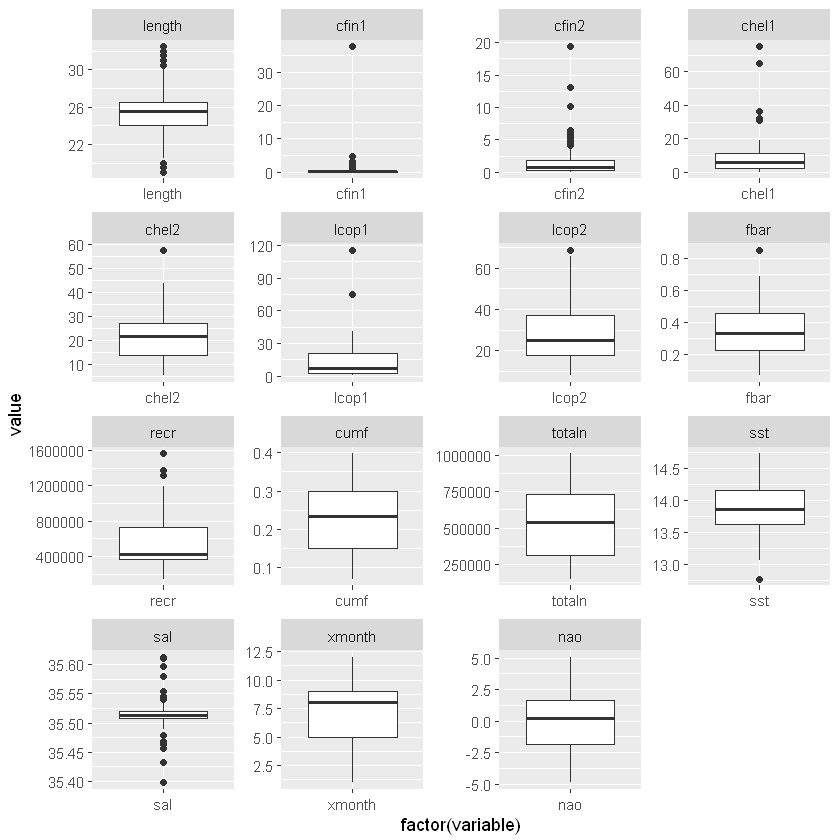

In [119]:
meltData <- melt(data, id.vars="X")
p <- ggplot(meltData, aes(factor(variable), value)) 
p + geom_boxplot() + facet_wrap(~variable, scale="free")

Jak widzimy w przypadku długości śledzia średnia jest w przybliżeniu w równej odległości od kwartyli Q1 i Q3. Pojawia się wiele outlierów.

Również dla zmiennej sal (poziom zasolenia) jest wiele wartości odstających, widocznie występują miejsca o szczególnie wysokim i niskim zasoleniu (np. niskie tam, gdzie rzeki wpadają do morza).

Dla zmiennej cfin1 (dostępność planktonu [zagęszczenie Calanus finmarchicus gat. 1]) obserwujemy niesymetryczny rozkład - albo tego rodzaju planktonu jest bardzo niewiele (w większości przypadków) albo bardzo dużo.

Spójrzmy na histogramy.

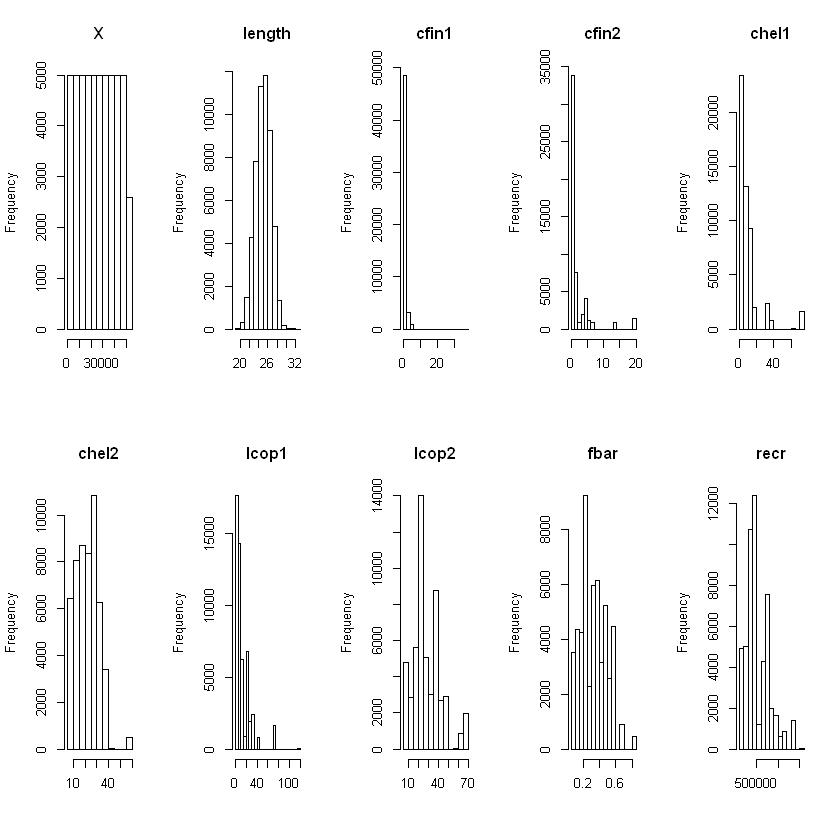

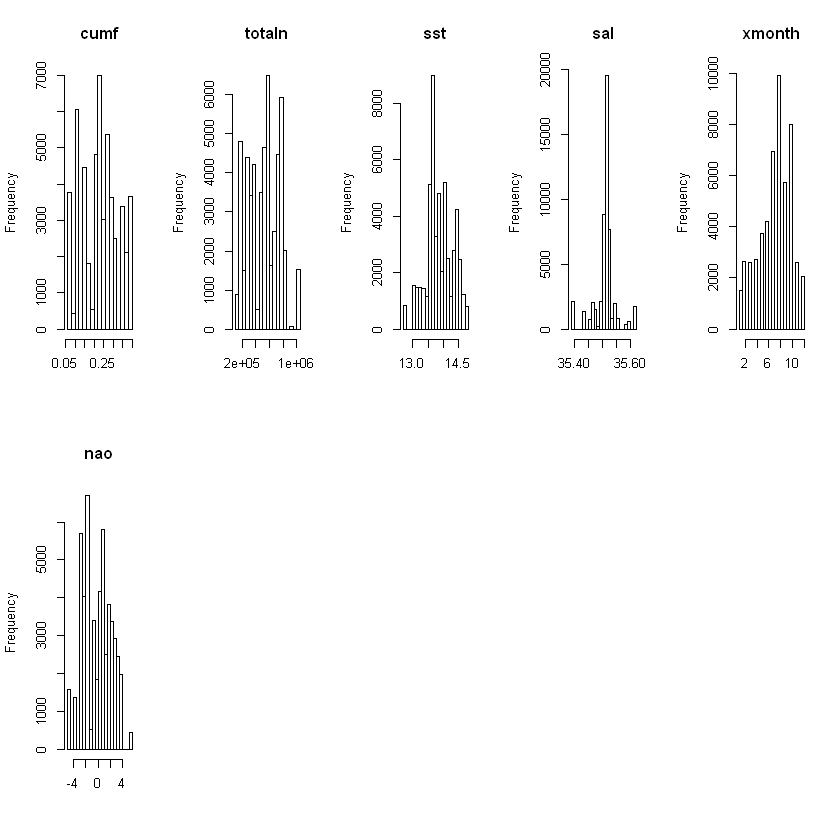

In [120]:
par(mfrow=c(2,5))
for (i in 1:length(data)) {
        hist(data[,i], main=names(data[i]), xlab="")
}

Do podobnych wniosków dochodzimy obserwując histogramy - rozkład cfin1 jest silnie prawoskośny, podobnie cfin2 i lcop1.

## 7. Sekcja sprawdzająca korelacje między zmiennymi; sekcja ta powinna zawierać jakąś formę graficznej prezentacji korelacji.

Po pierwsze zobaczmy, jak wielkość śledzia (length) zależy od czasu (X).

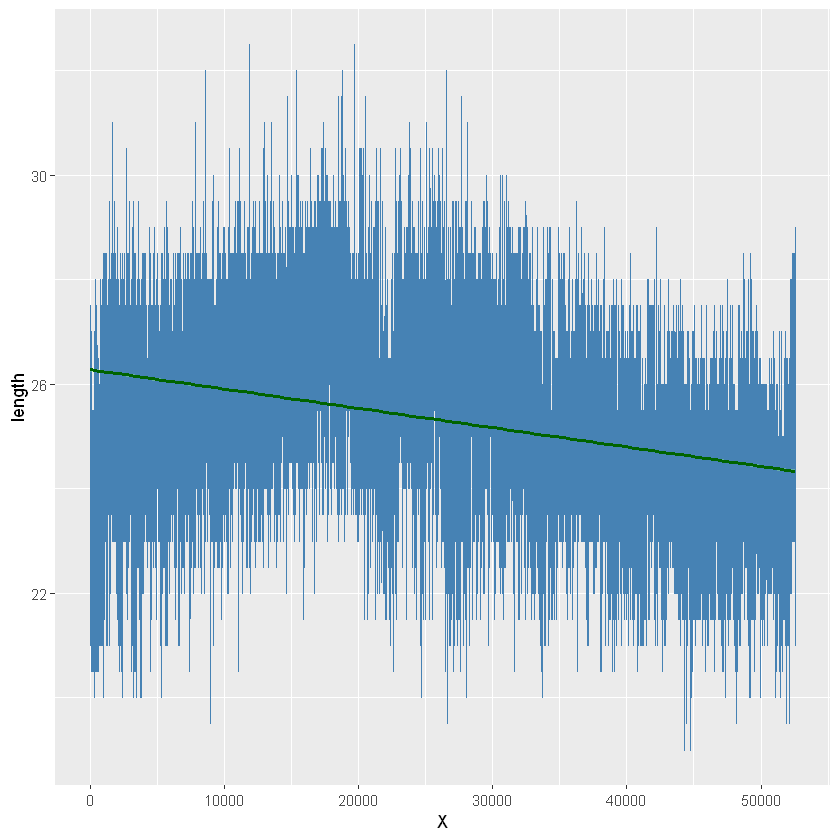

In [121]:
ggplot(data = data, aes(x=X, y=length, group=1)) +
  geom_line(color="steelblue") +
  geom_smooth(method="lm", fill="lightgreen", color="darkgreen", alpha=0.4) +
  theme_grey()

Widzimy tendencję malejącą, jednak wykres nie jest zbyt czytelny. Spróbujmy pogrupować dane.

W opisie danych jest informacja, że w zmiennej xmonth przechowywany jest miesiąc połowu.

In [122]:
head(data$xmonth, 100)

[1] 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 3 3 3 6 6 6 6
 [38] 6 3 3 3 3 3 3 3 3 3 3 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 5 5 5
 [75] 8 8 8 8 8 8 8 8 8 8 3 3 5 5 5 5 5 5 5 9 9 9 9 9 9 4

Okazuje się, że miesiące nie są podane chronologicznie ("6 6 5 5 3 3 3 6"), zatem nie można pogrupować na ich podstawie danych w lata.

Sprawdźmy zmienną recr, która opisuje roczny narybek.

In [123]:
length(unique(data$recr))

[1] 52

Przez 60 lat spodziewalibyśmy się 60 różnych wartości. Okazuje się, że jest ich 52, więc ta zmienna również się nie przyda.
Pogrupujmy zatem dane w kubełki o równej liczności (za wyjątkiem ostatniego) na podstawie kolejności chronologicznej (X).

In [124]:
numberOfYears = 60
rowsInYear = ceiling( nrow(data) / 60)
print(rowsInYear)
data_years <- data %>%  mutate(year = floor(X/rowsInYear) + 1)

[1] 877


In [125]:
head(data_years, 5)
tail(data_years, 5)

X,length,cfin1,cfin2,chel1,chel2,lcop1,lcop2,fbar,recr,cumf,totaln,sst,sal,xmonth,nao,year
0,23.0,0.02778,0.27785,2.46875,21.67333,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8,1
1,22.5,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8,1
2,25.0,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8,1
3,25.5,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8,1
4,24.0,0.02778,0.27785,2.46875,21.43548,2.54787,26.35881,0.356,482831,0.3059879,267380.8,14.30693,35.51234,7,2.8,1


,X,length,cfin1,cfin2,chel1,chel2,lcop1,lcop2,fbar,recr,cumf,totaln,sst,sal,xmonth,nao,year
52578,52577,24.0,1.02508,3.66319,6.42127,25.51806,10.92857,37.39201,0.485,724151,0.3838187,457143.9,13.7116,35.51169,11,2.05,60
52579,52578,26.0,1.02508,3.66319,6.42127,25.51806,10.92857,37.39201,0.485,724151,0.3838187,457143.9,13.7116,35.51169,11,2.05,60
52580,52579,25.0,1.02508,3.66319,6.42127,25.51806,10.92857,37.39201,0.485,724151,0.3838187,457143.9,13.7116,35.51169,11,2.05,60
52581,52580,25.0,0.36032,5.36402,4.32674,27.16006,5.08099,36.68770,0.434,441827,0.3726272,191976.2,14.4796,35.50777,6,-1.90,60
52582,52581,23.5,0.36032,5.36402,4.32674,27.16006,7.00000,36.68770,0.434,441827,0.3726272,191976.2,14.4796,35.50777,6,-1.90,60


In [126]:
plot_data <- data_years %>% group_by(year) %>% summarize(mean_length=mean(length), from = mean(length) - sd(length), to = mean(length) + sd(length))
plot_data

year,mean_length,from,to
1,23.75770,22.04112,25.47428
2,25.41334,23.92273,26.90396
3,25.19270,23.65274,26.73267
4,24.88940,23.29200,26.48679
5,25.20296,23.80239,26.60354
6,25.14994,23.81802,26.48186
7,25.09350,23.65872,26.52828
8,25.35120,24.00170,26.70070
9,25.46351,24.12292,26.80410
10,26.15393,24.90898,27.39889


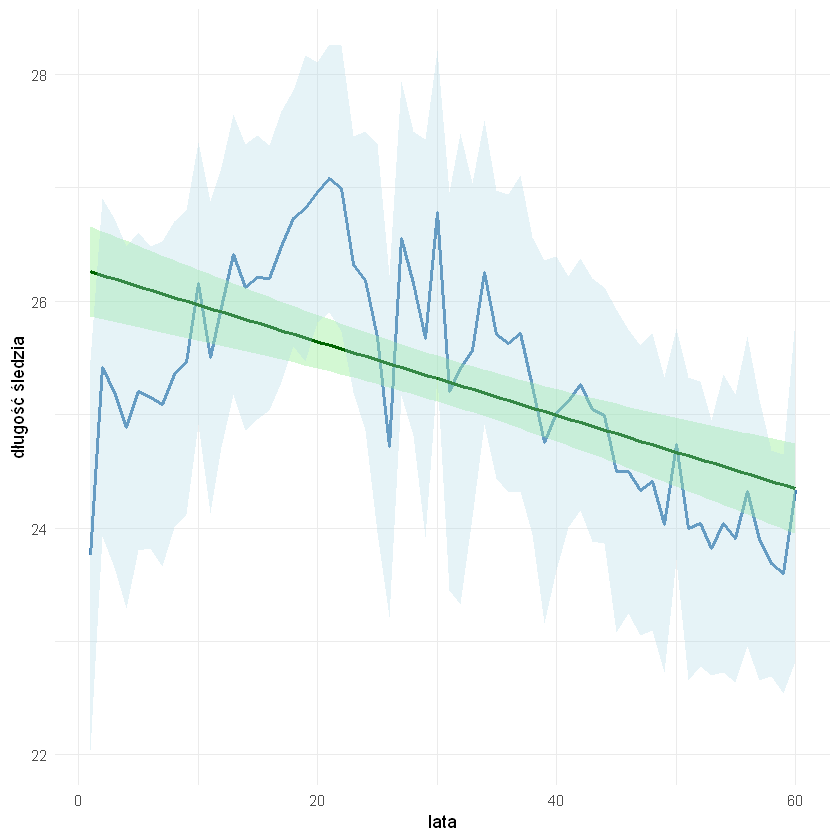

In [127]:
ggplot(data = plot_data, aes(x=year, y=mean_length, group=1)) +
  geom_line(size=1, color="steelblue") +
  geom_smooth(method="lm", fill="lightgreen", color="darkgreen") +
  geom_ribbon(aes(ymin = from, ymax = to), alpha = 0.3, fill="lightblue", color = "transparent") +
  xlab("lata") +
  ylab("długość śledzia") +
  theme_minimal()


Wykres jest czytelniejszy, widzimy, że długość śledzia maleje w czasie.

Narysujmy macierz korelacji.

In [128]:
cormat <- round(cor(data), 2)
cormat

,X,length,cfin1,cfin2,chel1,chel2,lcop1,lcop2,fbar,recr,cumf,totaln,sst,sal,xmonth,nao
X,1.00,-0.34,-0.15,0.06,-0.16,0.05,-0.22,0.04,0.09,0.00,0.23,-0.36,0.35,-0.06,0.00,0.41
length,-0.34,1.00,0.08,0.10,0.22,-0.01,0.23,0.05,0.25,-0.01,0.01,0.10,-0.45,0.03,0.01,-0.26
cfin1,-0.15,0.08,1.00,0.15,0.09,0.19,0.11,0.20,-0.06,0.11,-0.05,0.13,0.01,0.13,0.01,0.01
cfin2,0.06,0.10,0.15,1.00,0.00,0.30,-0.04,0.63,0.15,-0.10,0.33,-0.21,-0.23,-0.08,0.01,-0.01
chel1,-0.16,0.22,0.09,0.00,1.00,0.28,0.93,0.24,0.16,-0.05,0.07,0.16,-0.21,-0.15,0.05,-0.50
chel2,0.05,-0.01,0.19,0.30,0.28,1.00,0.17,0.86,0.03,0.00,0.26,-0.37,0.01,-0.22,0.07,-0.06
lcop1,-0.22,0.23,0.11,-0.04,0.93,0.17,1.00,0.14,0.09,0.00,-0.01,0.26,-0.26,-0.10,0.03,-0.54
lcop2,0.04,0.05,0.20,0.63,0.24,0.86,0.14,1.00,0.05,0.00,0.29,-0.30,-0.12,-0.18,0.06,-0.04
fbar,0.09,0.25,-0.06,0.15,0.16,0.03,0.09,0.05,1.00,-0.24,0.82,-0.51,-0.18,0.04,0.01,0.07
recr,0.00,-0.01,0.11,-0.10,-0.05,0.00,0.00,0.00,-0.24,1.00,-0.26,0.37,-0.20,0.28,0.02,0.09


In [129]:
melted_cormat <- melt(cormat)
head(melted_cormat)

Var1,Var2,value
X,X,1.00
length,X,-0.34
cfin1,X,-0.15
cfin2,X,0.06
chel1,X,-0.16
chel2,X,0.05


In [130]:
  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }

upper_tri <- get_upper_tri(cormat)

In [131]:
melted_cormat <- melt(upper_tri, na.rm = TRUE)

In [132]:
ggheatmap <- ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
  coord_fixed()


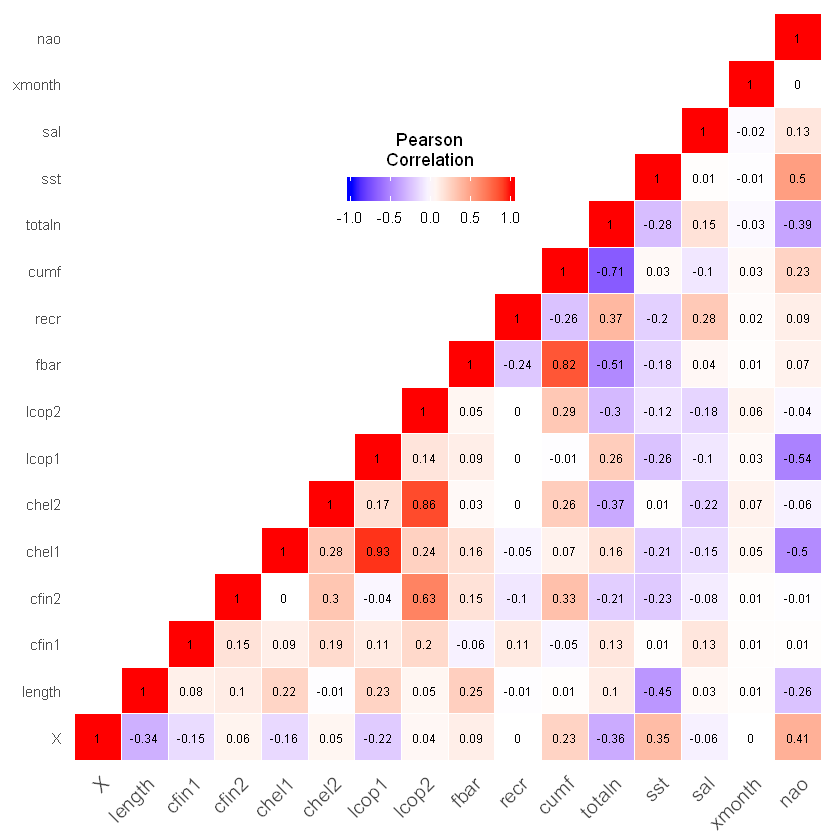

In [133]:
ggheatmap + 
geom_text(aes(Var2, Var1, label = value), color = "black", size = 2.5) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.7),
  legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))

Widzimy, że zmienne lcop1 (zagęszczenie widłonogów gat. 1) i chel1(zagęszczenie Calanus helgolandicus gat. 1) są bardzo mocno ze sobą skorelowane, więc jedną z nich można potencjalnie usunąć ze względu na redundancję. Podobnie lcop2 i chel2.

Duży współczynnik korelacji mają także cumf i fbar (obie zmienne opisują ułamek pozostawionego narybku). Cumf i length są praktycznie w ogóle nieskorelowane, dlatego decydujemy się usunąć cumf (jej wpływ na length jest prawie zerowy, więc można ją bezpiecznie usunąć).

In [134]:
data_reduced <- select(data, -c(chel1, chel2, cumf, X))

Ostatnim krokiem w tej sekcji będzie dokonanie analizy głównych składowych (PCA).
Ma to na celu zbadanie istotności cech.

In [135]:
pca <- prcomp(data, center = TRUE,scale. = TRUE)

summary(pca)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.8063 1.7766 1.3505 1.22974 1.09650 1.00144 0.97763
Proportion of Variance 0.2039 0.1973 0.1140 0.09452 0.07514 0.06268 0.05974
Cumulative Proportion  0.2039 0.4012 0.5152 0.60970 0.68485 0.74753 0.80726
                           PC8     PC9    PC10    PC11    PC12    PC13   PC14
Standard deviation     0.84486 0.81709 0.76491 0.67350 0.50501 0.45164 0.3047
Proportion of Variance 0.04461 0.04173 0.03657 0.02835 0.01594 0.01275 0.0058
Cumulative Proportion  0.85187 0.89360 0.93017 0.95852 0.97446 0.98721 0.9930
                          PC15    PC16
Standard deviation     0.24523 0.22735
Proportion of Variance 0.00376 0.00323
Cumulative Proportion  0.99677 1.00000

In [136]:
sum_variance <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
df <- data.frame(sum_variance = sum_variance,
                n=1:length(sum_variance))
df

sum_variance,n
0.2039268,1
0.4011992,2
0.5151849,3
0.6097017,4
0.6848462,5
0.7475263,6
0.8072615,7
0.8518735,8
0.8936010,9
0.9301691,10


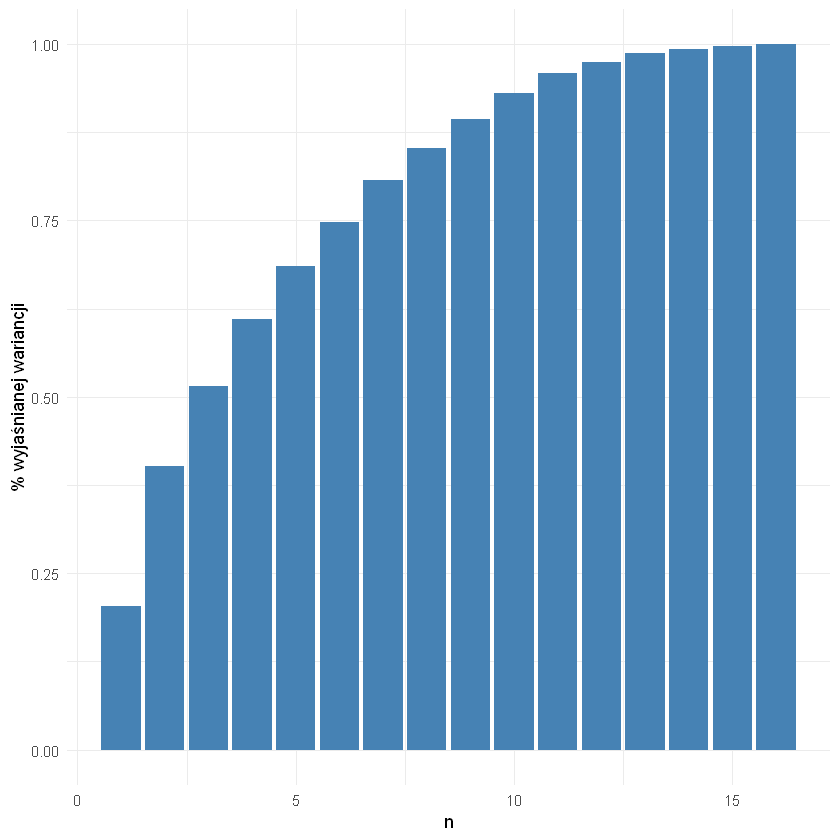

In [137]:
ggplot(data=df, aes(x=n, y=sum_variance)) +
  geom_bar(stat="identity", fill="steelblue")+
  theme_minimal() +
  xlab("n") +
  ylab("% wyjaśnianej wariancji") 

Na wykresie przedstawiono skumulowaną sumę wyjaśnianej wariancji dla pierwszych n głównych składowych.

Procent wyjaśnianej waraiancji gwałtownie rośnie dla pierwszych kilku n, a nasyca się w okolicach n = 11,
skąd można wysnuć wniosek, że nie wszystkie cechy są istotne i można zmniejszyć wymiarowość problemu.

## 8. Interaktywny wykres lub animacja prezentującą zmianę rozmiaru śledzi w czasie.

# *WYKRES STWORZONO PRZY UŻYCIU SHINY I ZNAJDUJE SIĘ W OSOBNYCH PLIKACH (SERVER I UI).*

## 9. Sekcja próbującą stworzyć regresor przewidujący rozmiar śledzia; dobór parametrów modelu oraz oszacowanie jego skuteczności powinny zostać wykonane za pomocą techniki podziału zbioru na dane uczące, walidujące i testowe; trafność regresji powinna zostać oszacowana na podstawie miar *R2* i *RMSE*.

Przypomijmy, że w wyniku analizy korelacji zdecydowaliśmy się na usunięcie zmiennych chel1, chel2, cumf, X ze względu na to, że przedstawia numer wiersza także decydujemy się usunąć.

In [138]:
data_reduced <- select(data, -c(chel1, chel2, cumf, X))

Przeprowadzamy podział na zbiory treningowy (do nauki), walidacyjny (do walidacji najlepszych parametrów) i testowy (na którym zdecydujemy się przetestować najlepszy algorytm).

In [139]:
inTrainingValidAll <- 
    createDataPartition(
        y = data_reduced$length,
        p = .8,
        list = FALSE)

In [140]:
training_valid_all <- data_reduced[ inTrainingValidAll,]
testing  <- data_reduced[-inTrainingValidAll,]

In [141]:
inTraining <- 
    createDataPartition(
        y = training_valid_all$length,
        p = .8,
        list = FALSE)

In [142]:
training <- training_valid_all[ inTraining,]
validating  <- training_valid_all[-inTraining,]

In [143]:
print(nrow(training))
print(nrow(validating))
print(nrow(testing))
print(nrow(data))

[1] 33655
[1] 8412
[1] 10515
[1] 52582


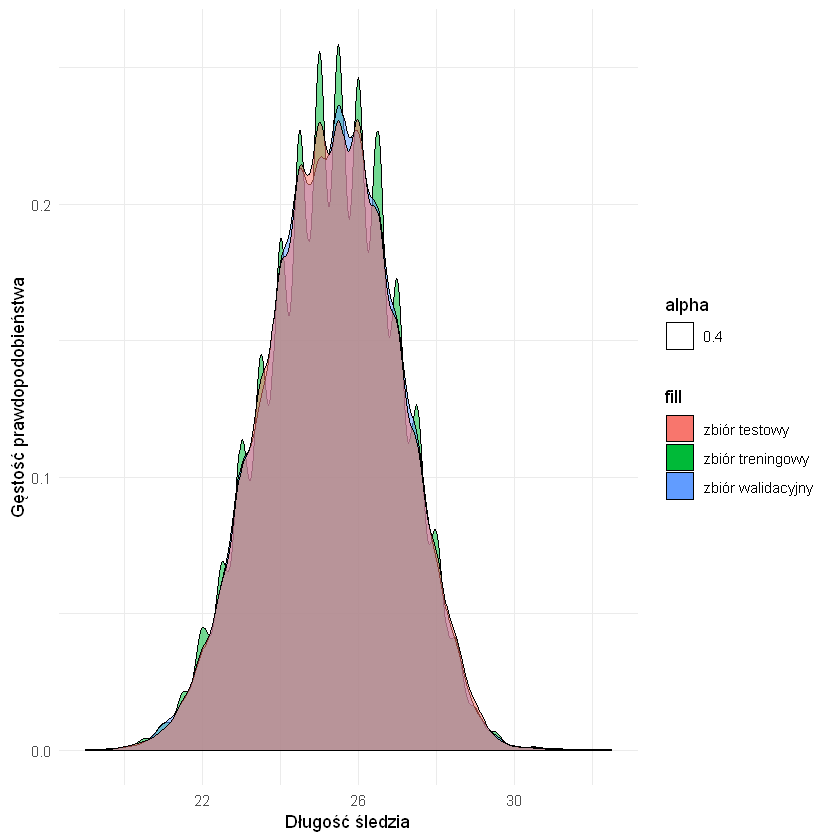

In [144]:
ggplot(mapping=aes(alpha=0.4)) + 
 geom_density(aes(training$length, fill="zbiór treningowy"), training) + 
 geom_density(aes(validating$length, fill="zbiór walidacyjny"), validating) + 
 geom_density(aes(testing$length, fill="zbiór testowy"), testing) + 
 theme_minimal() +
  xlab("Długość śledzia") +
  ylab("Gęstość prawdopodobieństwa") 

Widzimy, że próbkowanie zbioru danych nastąpiło poprawnie, w każdym typie zbioru występuje podobny rozkład zmiennej wyjściowej.

In [145]:
basic_model <- train(length ~ .,
               data = training,
               method = "lm")
basic_model

Linear Regression 

33655 samples
   11 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 33655, 33655, 33655, 33655, 33655, 33655, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  1.422033  0.265067  1.132041

Tuning parameter 'intercept' was held constant at a value of TRUE

Rozszerzmy model o powtarzaną kroswalidację.

In [146]:
ctrl <- trainControl(
    # powtórzona ocena krzyżowa
    method = "repeatedcv",
    # liczba podziałów
    number = 5,
    # liczba powtórzeń
    repeats = 3)

In [147]:
model <- train(length ~ .,
               data = training,
               trControl = ctrl,
               method = "lm")
model

Linear Regression 

33655 samples
   11 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 26923, 26924, 26925, 26924, 26924, 26924, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.424091  0.2637254  1.133492

Tuning parameter 'intercept' was held constant at a value of TRUE

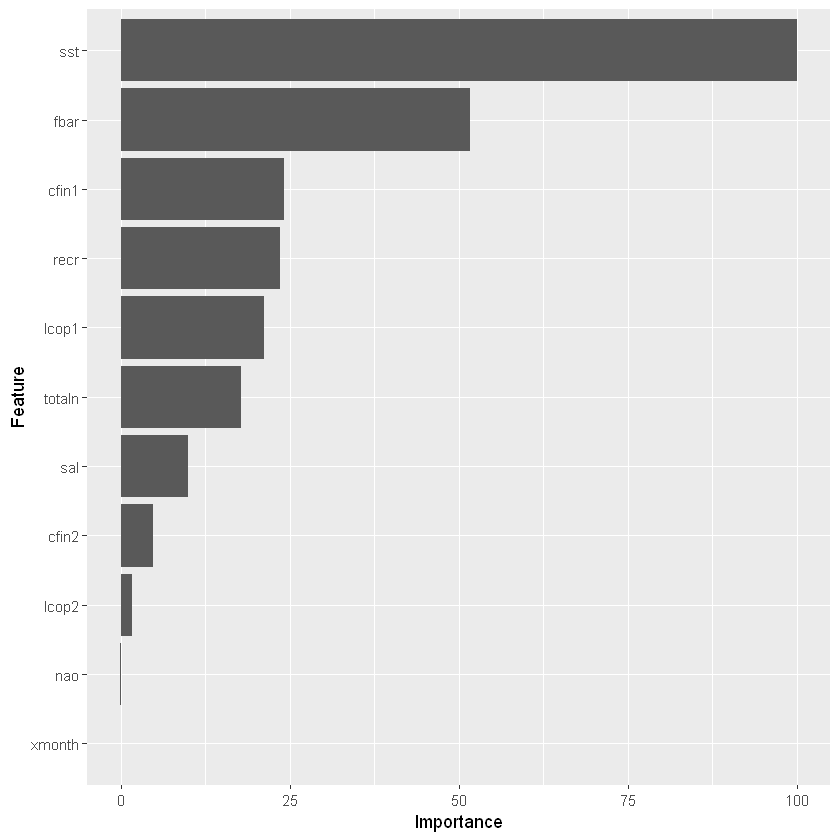

In [148]:
ggplot(varImp(model))

In [149]:
preprocessed_model <- train(length ~ .,
               data = training,
               trControl = ctrl,
               preProcess = c('scale', 'center'),
               method = "lm")

In [150]:
preprocessed_model

Linear Regression 

33655 samples
   11 predictor

Pre-processing: scaled (11), centered (11) 
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 26923, 26924, 26924, 26924, 26925, 26924, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.424087  0.2637934  1.133478

Tuning parameter 'intercept' was held constant at a value of TRUE

Preprocessing danych (skalowanie i centrowanie) niewiele pomogły. Spróbujmy innych rodzajów regresji.

In [151]:
lasso_model <- train(length ~ .,
               data = training,
               trControl = ctrl,
               preProcess = c('scale', 'center'),
               method = "lasso")

In [152]:
lasso_model

The lasso 

33655 samples
   11 predictor

Pre-processing: scaled (11), centered (11) 
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 26924, 26924, 26924, 26924, 26924, 26925, ... 
Resampling results across tuning parameters:

  fraction  RMSE      Rsquared   MAE     
  0.1       1.587939  0.2038671  1.280882
  0.5       1.448721  0.2473496  1.160785
  0.9       1.424408  0.2635382  1.133967

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was fraction = 0.9.

In [153]:
ridge_model <- train(length ~ .,
               data = training,
               trControl = ctrl,
               preProcess = c('scale', 'center'),
               method = "ridge")
ridge_model

Ridge Regression 

33655 samples
   11 predictor

Pre-processing: scaled (11), centered (11) 
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 26924, 26924, 26924, 26924, 26924, 26924, ... 
Resampling results across tuning parameters:

  lambda  RMSE      Rsquared   MAE     
  0e+00   1.424037  0.2637555  1.133489
  1e-04   1.424037  0.2637556  1.133486
  1e-01   1.425090  0.2627916  1.132254

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was lambda = 1e-04.

Root mean squared error (RMSE, błąd średniokwadratowy) oblicza się ze wzoru $sqrt(mean((pred - obs)^2$


$pred$ to przewidziane przez model wartości, a $obs$ to faktycznie zaobserwowane dane wyjściowe

R-squared ($R^2$) to współczynnik mówiący o tym jak dobrze dane wyliczone za pomocą modelu pasują do danych prawdziwych (współczynnik korelacji między nimi do kwadratu), zatem chcemy minimalizować RMSE i maksymualizować R-squared.

In [154]:
predictions <- predict(model, validating)
postResample(pred = predictions, obs = validating$length)

RMSE  Rsquared       MAE 
1.4161289 0.2546054 1.1348544

In [155]:
predictions <- predict(preprocessed_model, validating)
postResample(pred = predictions, obs = validating$length)

RMSE  Rsquared       MAE 
1.4161289 0.2546054 1.1348544

In [156]:
predictions <- predict(lasso_model, validating)
postResample(pred = predictions, obs = validating$length)

RMSE Rsquared      MAE 
1.416429 0.254148 1.135109

In [157]:
predictions <- predict(ridge_model, validating)
postResample(pred = predictions, obs = validating$length)

RMSE  Rsquared       MAE 
1.4161294 0.2546051 1.1348521

Wszystkie modele działają praktycznie tak samo. Spróbujmy jeszcze wytrenować regresor na wszystkich kolumnach.

In [158]:
all_training_valid_all <- data[ inTrainingValidAll,]
all_testing  <- data[-inTrainingValidAll,]
all_training <- data[ inTraining,]
all_validating  <- data[-inTraining,]

In [159]:
all_ridge_model <- train(length ~ .,
               data = all_training,
               trControl = ctrl,
               preProcess = c('scale', 'center'),
               method = "ridge")
all_ridge_model

Ridge Regression 

33655 samples
   15 predictor

Pre-processing: scaled (15), centered (15) 
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 26924, 26923, 26925, 26924, 26924, 26924, ... 
Resampling results across tuning parameters:

  lambda  RMSE      Rsquared   MAE     
  0e+00   1.339599  0.2831957  1.059560
  1e-04   1.339599  0.2831958  1.059557
  1e-01   1.356933  0.2663379  1.072745

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was lambda = 1e-04.

In [160]:
predictions <- predict(all_ridge_model, all_validating)
postResample(pred = predictions, obs = all_validating$length)

RMSE  Rsquared       MAE 
1.4715463 0.2680142 1.1656247

Biorąc pod uwagę RMSE można wysnuć wniosek, że redukcja atrybutów była dobrym posunięciem.

## 10. Analiza ważności atrybutów najlepszego znalezionego modelu regresji.
Przyjrzyjmy się najważniejszym cechom według trenowanych modeli regresji.

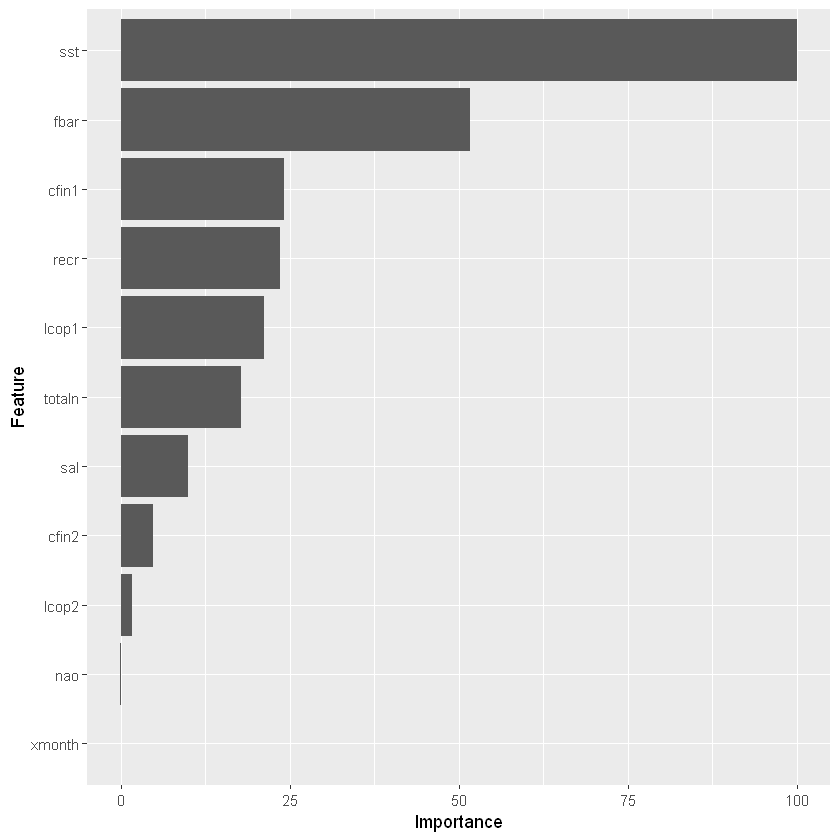

In [161]:
ggplot(varImp(preprocessed_model))

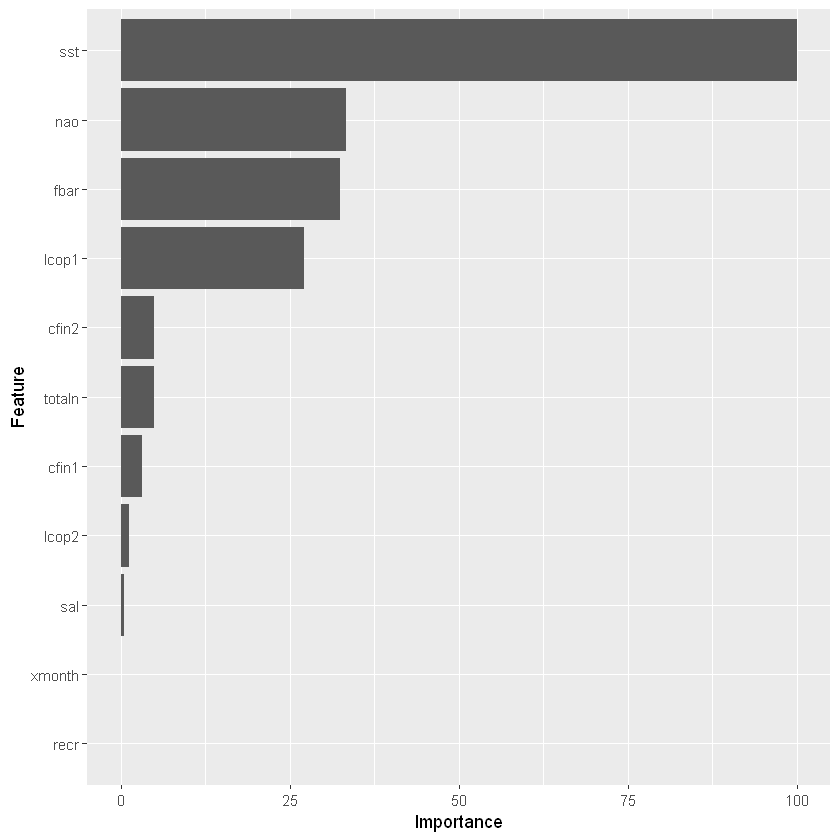

In [162]:
ggplot(varImp(lasso_model))

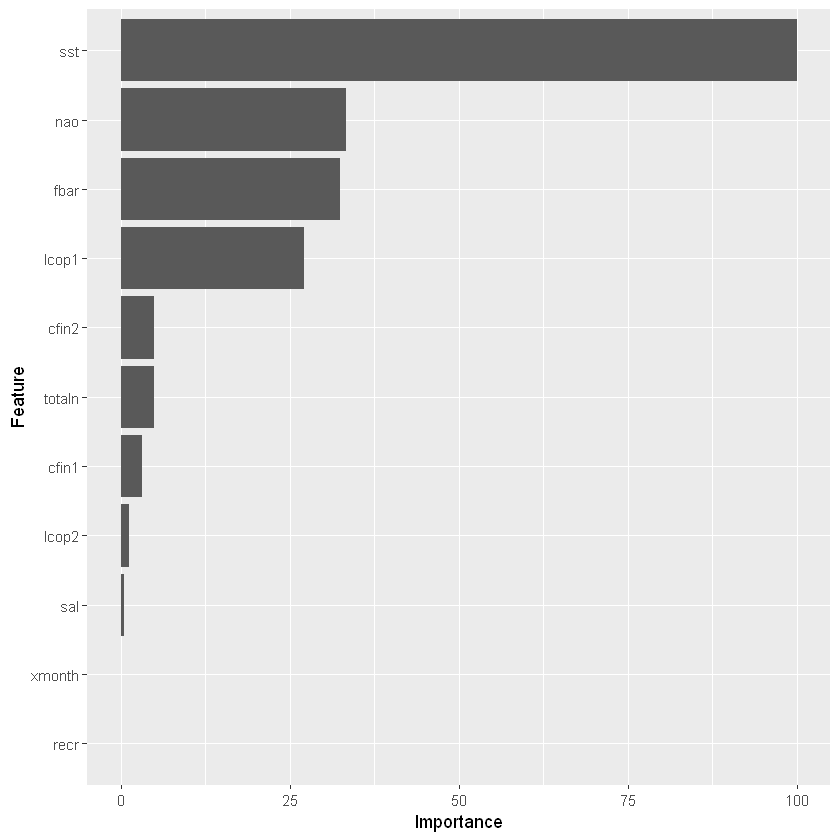

In [163]:
ggplot(varImp(ridge_model))

W badanych modelach dużą ważność mają następujące cechy:
- sst (temperatura przy powierzchni wody [°C])
- fbar (natężenie połowów w regionie [ułamek pozostawionego narybku])
- nao (nao: oscylacja północnoatlantycka [mb]) - w regresjach typu lasso i ridge
- lcop1: dostępność planktonu [zagęszczenie widłonogów gat. 1]


Stąd można wysnuć wniosek, że na wielkość śledzia mają największy wpływ powyższe czynniki.

Uznajmy, że model ridge za osteczny i dokonajmy predykcji na zbiorze testowym.

In [164]:
test_predictions <- predict(ridge_model, testing)
postResample(pred = test_predictions, obs = testing$length)

RMSE  Rsquared       MAE 
1.4221289 0.2496654 1.1350627

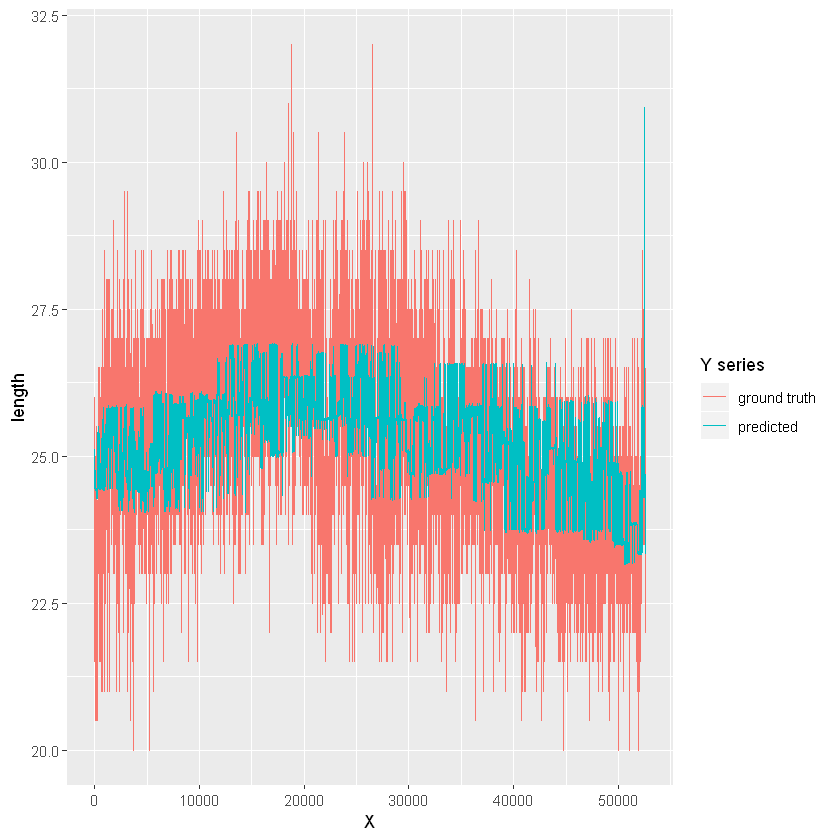

In [165]:
ggplot(testing, aes(all_testing$X)) +
 geom_line(aes(y = testing$length, colour = "blue")) +
 geom_line(aes(y = test_predictions, colour = "green")) +
 xlab("X") +
 ylab("length") + 
 scale_color_discrete(name = "Y series", labels = c("ground truth", "predicted")) +
 theme_grey()

Model dobrze przewiduje długość śledzia w poszczególnych okresach, nie uwzględnia dużych wahań długości w krótkich odstępach czasu (generalizuje).

Na koniec zwizualizujmy zależności między odkrytymi ważnymi cechami a zmienną y (length, długość śledzia)

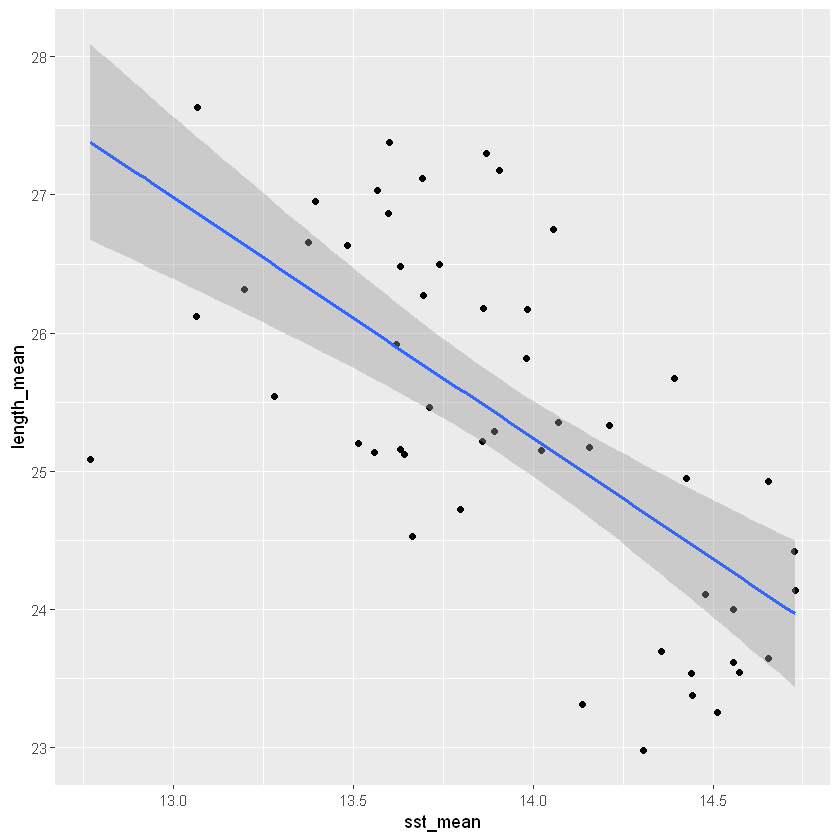

In [166]:
by_sst <- data %>%
  group_by(sst) %>%
  summarise(sst_mean = mean(sst), length_mean = mean(length))
ggplot(by_sst,  aes(x=sst_mean,y=length_mean)) +
geom_point() + geom_smooth(method='lm')

Im wyższa temperatura przy powierzchni, tym krótsze śledzie.

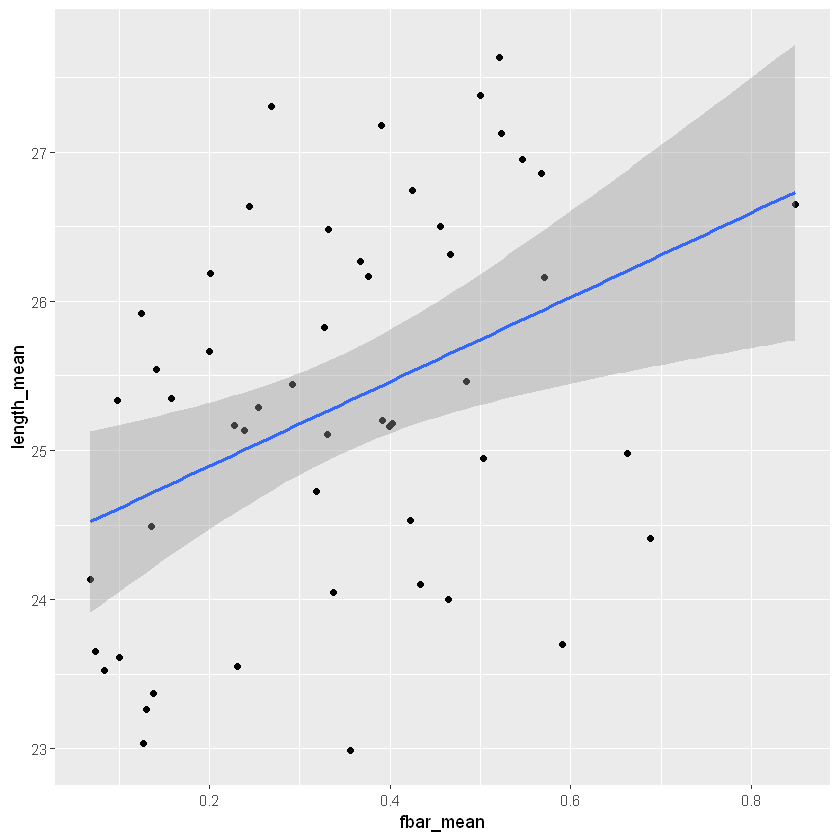

In [167]:
by_fbar <- data %>%
  group_by(fbar) %>%
  summarise(fbar_mean = mean(fbar), length_mean = mean(length))
ggplot(by_fbar,  aes(x=fbar_mean,y=length_mean)) +
geom_point() + geom_smooth(method='lm')

Im więcej pozostanie narybku, tym dłuższe śledzie.

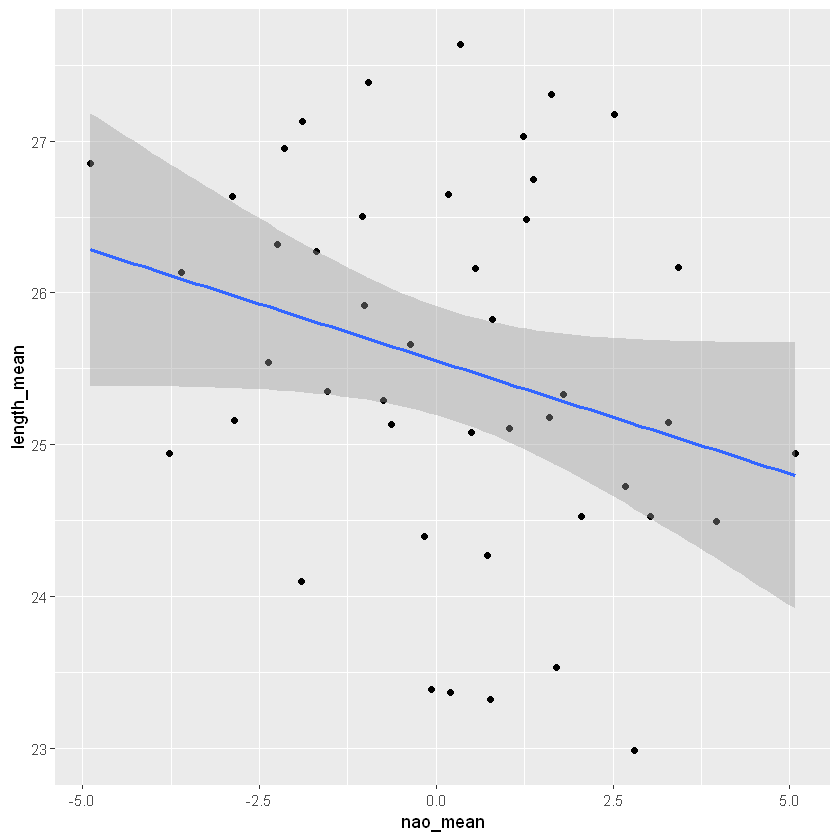

In [168]:
by_nao <- data %>%
  group_by(nao) %>%
  summarise(nao_mean = mean(nao), length_mean = mean(length))
ggplot(by_nao,  aes(x=nao_mean,y=length_mean)) +
geom_point() + geom_smooth(method='lm')

Im większe nao (Oscylacja północnoatlantycka), tym krótsze śledzie.

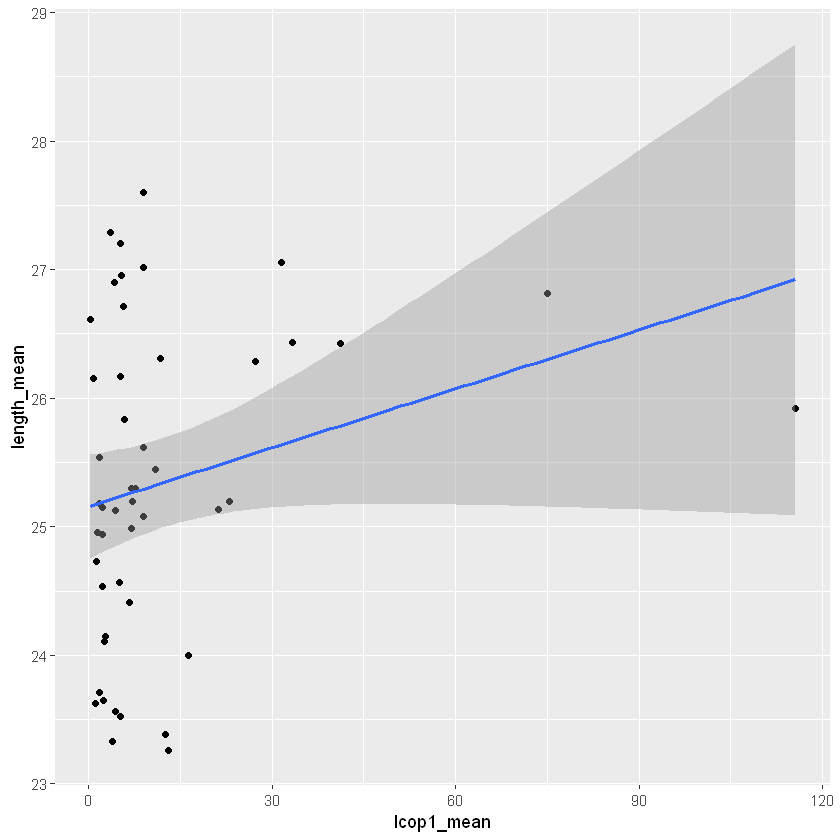

In [169]:
by_lcop1 <- data %>%
  group_by(lcop1) %>%
  summarise(lcop1_mean = mean(lcop1), length_mean = mean(length))
ggplot(by_lcop1,  aes(x=lcop1_mean,y=length_mean)) +
geom_point() + geom_smooth(method='lm')

Im większa dostępność planktonu [zagęszczenie widłonogów gat. 1], tym dłuższe śledzie.